## Preparation + build model

In [1]:
import numpy as np
import pandas as pd
Train_df = pd.read_csv('./data/train_newfeature.csv')
Valid_df = pd.read_csv('./data/valid_newfeature.csv')

In [2]:
#Samp_per should be in 0.001,0.01,0.025,0.05,0.075,0.1
Samp_per=0.1
# bids which click =1
df1 = Train_df[Train_df['click']==1]
# bids which click =0
df0 = Train_df[Train_df['click']==0]
# get 10% of click =0 data, down sampling
df2=df0.sample(frac=Samp_per)
# combine 10% of click =0 data and all click=1, down sampling
combined_df = pd.concat([df1, df2],axis=0)
combined_df.head()
combined_df.shape
#new trainning set shape is(62523, 127)

(244712, 127)

In [3]:
# combined_df.to_csv('/Users/weisihan/Desktop/ourtrainingset_Simple_XGBoost_model_25.csv', encoding='utf-8', index=False)

In [4]:
cols=list(Train_df.columns)[1:]

In [5]:
train_y = combined_df['click']
train_x = combined_df[cols]

In [6]:
import xgboost

xgb = xgboost.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=6,
 min_child_weight=7,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
#modelfit(xgb4, train, predictors)

In [7]:
#train xgboost model
import xgboost
X = train_x
y = train_y
# train the default model
#model = xgboost.XGBClassifier()
model = xgb
model.fit(X, y)
#14:15-14:16

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=7, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1, seed=27,
       silent=True, subsample=0.8)

In [8]:
import matplotlib.pyplot as plt

In [9]:
import xgboost

In [14]:
fig, ax = plt.subplots(figsize=(5, 8))
xgboost.plot_importance(model, ax=ax, max_num_features=20)

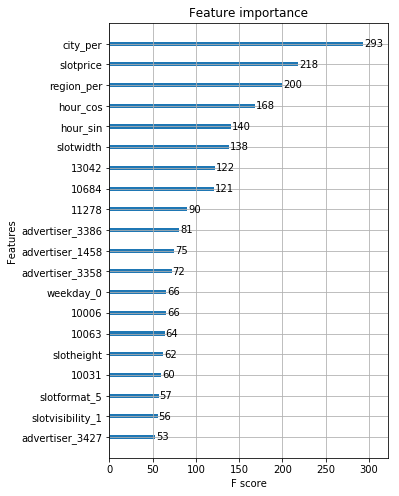

In [15]:
plt.show()

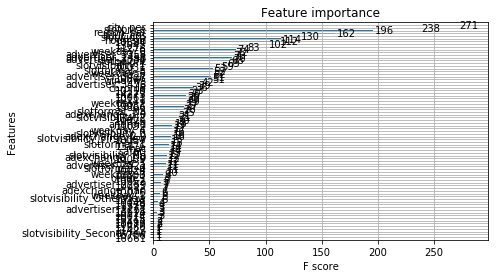

In [9]:
xgboost.plot_importance(model)
plt.show()

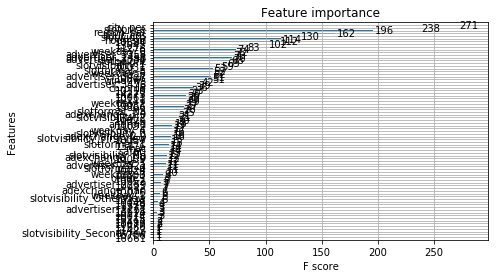

In [11]:
plt.figure(figsize = (8, 20))
xgboost.plot_importance(model)
plt.show()

In [7]:
from sklearn.externals import joblib

filename = 'Simple_XGBoost_model_25.sav'
joblib.dump(model, filename)

['Simple_XGBoost_model_25.sav']

In [8]:
#test the default model
valid_x = Valid_df[cols]
valid_predictions = model.predict_proba(valid_x)
valid_predictions_class = model.predict(valid_x)

In [9]:
valid_predictions[:,1]

array([ 0.0048371 ,  0.00371052,  0.00353499, ...,  0.04820345,
        0.01614958,  0.00819073], dtype=float32)

In [10]:
valid_result = pd.DataFrame(columns=['click', 'click_pred_per', 'click_pred_class'])  
valid_result['click']= Valid_df['click'].copy()
valid_result['click_pred_per'] = valid_predictions[:,1]
valid_result['click_pred_class'] = valid_predictions_class
valid_result.head()

click  click_pred_per  click_pred_class
0      0        0.004837                 0
1      0        0.003711                 0
2      0        0.003535                 0
3      0        0.004851                 0
4      0        0.004998                 0

## calibrate pCTR

In [11]:
def recalibrate(p,w):
    q = p/(p+(1-p)/w)
    return q

In [12]:
valid_result['click_pred_per']=recalibrate(valid_result['click_pred_per'],0.025)
valid_result.head()

click  click_pred_per  click_pred_class
0      0        0.000122                 0
1      0        0.000093                 0
2      0        0.000089                 0
3      0        0.000122                 0
4      0        0.000126                 0

 随便看一下

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


y_test = valid_result['click']
y_pred_class = valid_result['click_pred_class']

print(confusion_matrix(y_test, y_pred_class))

confusion = confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print ("TP:", TP)
print ("TN:", TN)
print ("FP:", FP)
print ("FN:", FN)

#准确率、识别率（Classification Accuracy）：分类器正确分类的比例
#print ((TP+TN) / float(TP+TN+FN+FP))
print ("Accuracy: %.6f%%" % (accuracy_score(y_test, y_pred_class)* 100.0) )

#灵敏性（Sensitivity），也称为真正例识别率、召回率（Recall）：正确识别的正例数据在实际正例数据中的百分比
#print (TP / float(TP+FN))
#recall = metrics.recall_score(y_test, y_pred_class)
print ("Recall: %.6f%%" % (recall_score(y_test, y_pred_class)* 100.0))

#特效性（Specificity），也称为真负例率：正确识别的负例数据在实际负例数据中的百分比
print ("Specificity: %.6f%%" % (TN / float(TN+FP)* 100.0))

#假阳率（False Positive Rate）：实际值是负例数据，预测错误的百分比
#print (FP / float(TN+FP))
specificity = TN / float(TN+FP)
print ("False Positive Rate: %.6f%%" %((1 - specificity)*100.0))

#精度（Precision）：看做精确性的度量，即标记为正类的数据实际为正例的百分比
#print (TP / float(TP+FP))
precision = precision_score(y_test, y_pred_class)
print ("Precision: %.6f%%" %(precision*100.0))

#F1（平衡F分数）：精确率和召回率的调和平均数
#print (TP / float(TP+FP))
f1 = f1_score(y_test, y_pred_class)
print ("F1 score: %.6f%%" %(f1*100.0))



[[303363    360]
 [   129     73]]
TP: 73
TN: 303363
FP: 360
FN: 129
Accuracy: 99.839105%
Recall: 36.138614%
Specificity: 99.881471%
False Positive Rate: 0.118529%
Precision: 16.859122%
F1 score: 22.992126%


## Find Base Bid ----QR's Code

In [15]:
df_valid = pd.read_csv("/Users/weisihan/Downloads/we_data/validation.csv")

In [16]:
# parameters
total_budget = 6250000
payprice = df_valid['payprice'].as_matrix()
Train_df_qr = df_valid.copy()
test_predictions=valid_result['click_pred_per']
#test_predictions1=test_result['click_pred_per']

avgCTR = 1793/2430981 #train set
#tuning...

In [17]:
def generate_bidprice(base_bid, test_predictions):
    avgCTR = 1793/2430981#train set
    bidprices = base_bid*test_predictions/avgCTR
    return bidprices

In [18]:
def Prob3(Train_df,payprice,base_bid,test_predictions):
    Train_Const_summ = pd.DataFrame({'Clicks':'', 'Spend':'', 'CTR':'', 'CPM':'', 'eCPC':''}, index=[0])
    
    #if count_break = 5 break
    count_break = 0
    
    current_budget = total_budget
    Train_df['win'] = 0 #initialize win label
    bidprices = generate_bidprice(base_bid, test_predictions)
    #start biding...
    for i in Train_df.index:
    #for i in range(Train_df.shape[0]):
#         if current_budget >= bidprices[i]:
#         if current_budget > 0:
            #generate bidprice:
        current_bidprice = bidprices[i]
        #consider budget
        if current_budget <= current_bidprice:              
            #count lack budget times
            count_break = count_break + 1
            print('lack of budget!',"current_budget:",current_budget,";current_bidprice:",current_bidprice,';count_break:',count_break)
            if count_break > 5:
                break  
            #reset bidprice
            current_bidprice = current_budget
        else:
            count_break = 0
            

        #Winning criterion:
        current_payprice = payprice[i]
        if current_bidprice > current_payprice:
            Train_df.at[i, 'win'] = int(1)
            current_budget = current_budget - current_payprice
        else:
            Train_df.at[i, 'win'] = int(0)

    #biding end        
    
    Train_df_new = Train_df[Train_df['win']!=0]
    #wintimes,_ = Train_df_new.shape
    #print('wintimes:',wintimes)
    #print('current_budget',current_budget)

    Clk = Train_df_new['click'].sum()
    Imp = Train_df_new['click'].count()
    CTR = Clk/Imp
    Spd = total_budget - current_budget
    CPM = 1000*Spd/Imp
    eCPC = Spd/Clk
    
    Train_Const_summ.loc[0,'Clicks']=Clk
    Train_Const_summ.loc[0,'Spend']=Spd
    Train_Const_summ.loc[0,'CTR']=CTR
    Train_Const_summ.loc[0,'CPM']=CPM
    Train_Const_summ.loc[0,'eCPC']=eCPC

    print(Train_Const_summ)
    
        
    return Train_df,current_budget

In [19]:
def calculate_click(base_bid,Train_df,payprice,test_predictions):
    print('base_bid:',base_bid)
    result_df,current_budget = Prob3(Train_df,payprice,base_bid,test_predictions)
    print('current_budget:',current_budget)
    Train_df_new = result_df[result_df['win']!=0]
    wintimes,_ = Train_df_new.shape
    print('wintimes:',wintimes)
    print('----------------')
    Clk = Train_df_new['click'].sum()    
    return Clk

In [20]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import mpld3
import numpy as np

In [21]:
base_bids = np.arange(125,136,1)#区间可以适当左右调整一下，但大概就是这个范围
Clks = [calculate_click(base_bid,Train_df_qr,payprice,test_predictions) for base_bid in base_bids]
fig = plt.figure()
print(max(Clks))
plt.plot(base_bids,Clks)
mpld3.display(fig)

base_bid: 125
       CPM         CTR Clicks    Spend     eCPC
0  45958.3  0.00131072    166  5820526  35063.4
current_budget: 429474
wintimes: 126648
----------------
base_bid: 126
     CPM         CTR Clicks    Spend     eCPC
0  46081  0.00130278    166  5871636  35371.3
current_budget: 378364
wintimes: 127420
----------------
base_bid: 127
     CPM         CTR Clicks    Spend     eCPC
0  46191  0.00129541    166  5919148  35657.5
current_budget: 330852
wintimes: 128145
----------------
base_bid: 128
       CPM        CTR Clicks    Spend     eCPC
0  46312.9  0.0012877    166  5970289  35965.6
current_budget: 279711
wintimes: 128912
----------------
base_bid: 129
       CPM         CTR Clicks    Spend     eCPC
0  46419.1  0.00127984    166  6020740  36269.5
current_budget: 229260
wintimes: 129704
----------------
base_bid: 130
       CPM         CTR Clicks    Spend     eCPC
0  46522.6  0.00127246    166  6069146  36561.1
current_budget: 180854
wintimes: 130456
----------------
base_bid

## Test + Submission

In [ ]:
Test_df = pd.read_csv('/Users/weisihan/Downloads/we_data/mytestset.csv')
Group=  pd.read_csv('/Users/weisihan/Downloads/we_data/Group_xx.csv')

In [ ]:
Test_df = Test_df[['slotwidth', 'slotheight', 'slotprice', 'android', 'ios',
       'linux', 'mac', 'other', 'windows', 'chrome', 'firefox', 'ie',
       'maxthon', 'opera', 'other.1', 'safari', 'sogou', 'theworld',
       '10006', '10024', '10031', '10048', '10052', '10057', '10059',
       '10063', '10067', '10074', '10075', '10076', '10077', '10079',
       '10083', '10093', '10102', '10110', '10111', '10114', '10115',
       '10116', '10117', '10118', '10120', '10123', '10125', '10126',
       '10127', '10129', '10130', '10131', '10133', '10138', '10140',
       '10142', '10145', '10146', '10147', '10148', '10149', '10684',
       '11092', '11278', '11379', '11423', '11512', '11576', '11632',
       '11680', '11724', '11944', '13042', '13403', '13496', '13678',
       '13776', '13800', '13866', '13874', '14273', '15398', '16593',
       '16617', '16661', '16706', '16751', '16753', 'hour_sin', 'hour_cos',
       'city_per', 'region_per', 'weekday_0', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       'adexchange_1.0', 'adexchange_2.0', 'adexchange_3.0',
       'adexchange_4.0', 'adexchange_nan', 'slotvisibility_0',
       'slotvisibility_1', 'slotvisibility_2', 'slotvisibility_255',
       'slotvisibility_FifthView', 'slotvisibility_FirstView',
       'slotvisibility_FourthView', 'slotvisibility_Na',
       'slotvisibility_OtherView', 'slotvisibility_SecondView',
       'slotvisibility_ThirdView', 'slotformat_0', 'slotformat_1',
       'slotformat_5', 'slotformat_Na', 'advertiser_1458',
       'advertiser_2259', 'advertiser_2261', 'advertiser_2821',
       'advertiser_2997', 'advertiser_3358', 'advertiser_3386',
       'advertiser_3427', 'advertiser_3476']]

In [ ]:
test_x = Test_df
test_predictions = model.predict_proba(test_x)
test_predictions_class = model.predict(test_x)

In [ ]:
test_result = pd.DataFrame(columns=['bidprice', 'click_pred_per', 'click_pred_class'])  
test_result['click_pred_per'] = test_predictions[:,1]
test_result['click_pred_class'] = test_predictions_class
test_result.head()

In [ ]:
test_result['click_pred_per']=recalibrate(test_result['click_pred_per'],Samp_per)
test_result.head()

In [ ]:
base_bid=133
#这个变成你测出来最高clk的basebid！！！！！！！
avgCTR = 1793/2430981#train set
test_result['bidprice'] = base_bid*test_result['click_pred_per']/avgCTR
test_result.head()

In [ ]:
Group['bidprice']=test_result['bidprice']
Group.head()

In [ ]:
Group.to_csv('/Users/weisihan/Desktop/Group_6.csv', encoding='utf-8', index=False)